# Day 3: Feature Selection - Filter Methods

## Learning Objectives
- Understand filter-based feature selection
- Implement correlation analysis and mutual information
- Handle multicollinearity in financial features

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("✅ Libraries loaded!")
print("📚 Day 3: Feature Selection - Filter Methods")

✅ Libraries loaded!
📚 Day 3: Feature Selection - Filter Methods


In [2]:
# ============================================================
# BUILD FEATURE SET
# ============================================================

print("BUILDING FEATURE SET")
print("="*60)

np.random.seed(42)
n_days = 1500

# Generate returns
returns = np.random.normal(0.0002, 0.015, n_days)
for i in range(1, len(returns)):
    returns[i] += 0.05 * returns[i-1]

prices = 100 * np.cumprod(1 + returns)
df = pd.DataFrame({'price': prices, 'returns': returns})

# Create comprehensive features (start from 5 for rolling, since std needs at least 2 values)
for h in [5, 10, 20]:
    df[f'ret_{h}d'] = df['price'].pct_change(h)
    df[f'vol_{h}d'] = df['returns'].rolling(h).std()
    df[f'mom_{h}d'] = df['returns'].rolling(h).sum()

# RSI
gains = df['returns'].where(df['returns'] > 0, 0).rolling(14).mean()
losses = (-df['returns'].where(df['returns'] < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gains / (losses + 1e-10)))

# MA features
df['ma_ratio_5_20'] = df['price'].rolling(5).mean() / df['price'].rolling(20).mean()
df['ma_ratio_10_50'] = df['price'].rolling(10).mean() / df['price'].rolling(50).mean()

# BB position
ma20 = df['price'].rolling(20).mean()
std20 = df['price'].rolling(20).std()
df['bb_position'] = (df['price'] - (ma20 - 2*std20)) / (4*std20)

# Target
df['target'] = (df['returns'].shift(-1) > 0).astype(int)

df = df.dropna()
print(f"Data: {len(df)} samples, {len(df.columns)-2} features")

BUILDING FEATURE SET
Data: 1451 samples, 14 features


## Part 1: Correlation Analysis

CORRELATION WITH TARGET

Top 10 by correlation with target:
  vol_5d               0.0261
  vol_20d              0.0244
  vol_10d              0.0232
  ma_ratio_5_20        0.0143
  ma_ratio_10_50       0.0080
  bb_position          0.0064
  mom_20d              0.0050
  ret_20d              0.0048
  rsi                  0.0040
  mom_10d              0.0022


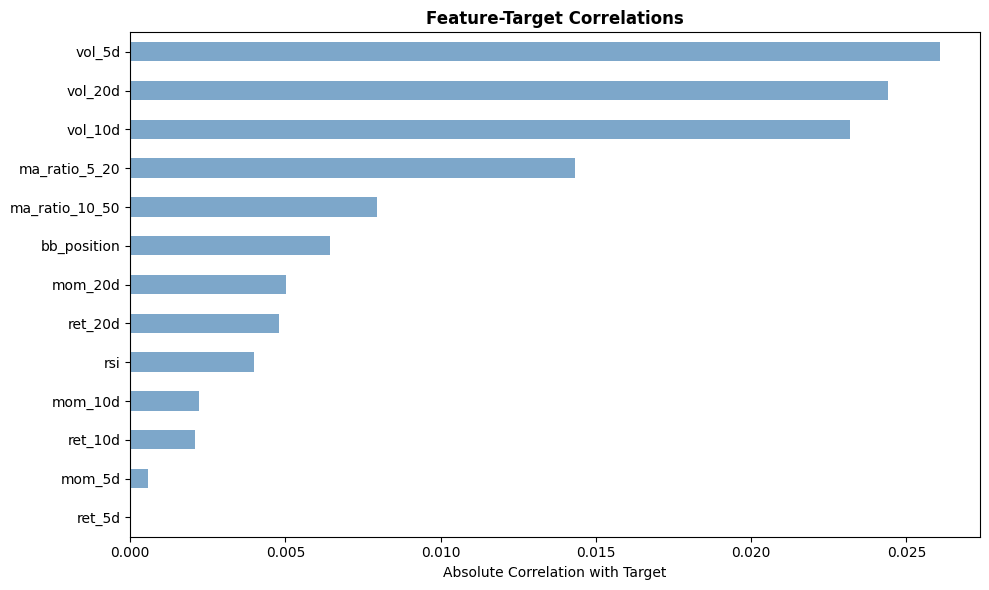

In [3]:
# ============================================================
# CORRELATION WITH TARGET
# ============================================================

print("CORRELATION WITH TARGET")
print("="*60)

feature_cols = [c for c in df.columns if c not in ['price', 'returns', 'target']]

# Pearson correlation with target
correlations = df[feature_cols].corrwith(df['target']).abs().sort_values(ascending=False)

print("\nTop 10 by correlation with target:")
for feat, corr in correlations.head(10).items():
    print(f"  {feat:<20} {corr:.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
correlations.head(15).plot(kind='barh', ax=ax, color='steelblue', alpha=0.7)
ax.set_xlabel('Absolute Correlation with Target')
ax.set_title('Feature-Target Correlations', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

FEATURE CORRELATIONS

Highly correlated pairs (>0.8):
  ret_5d <-> mom_5d: 1.000
  ret_10d <-> mom_10d: 1.000
  ret_20d <-> mom_20d: 0.999
  rsi <-> ma_ratio_5_20: 0.908
  ret_20d <-> ma_ratio_5_20: 0.867
  mom_20d <-> ma_ratio_5_20: 0.866
  ret_10d <-> ma_ratio_5_20: 0.862
  mom_10d <-> ma_ratio_5_20: 0.861
  mom_10d <-> bb_position: 0.855
  ret_10d <-> bb_position: 0.852


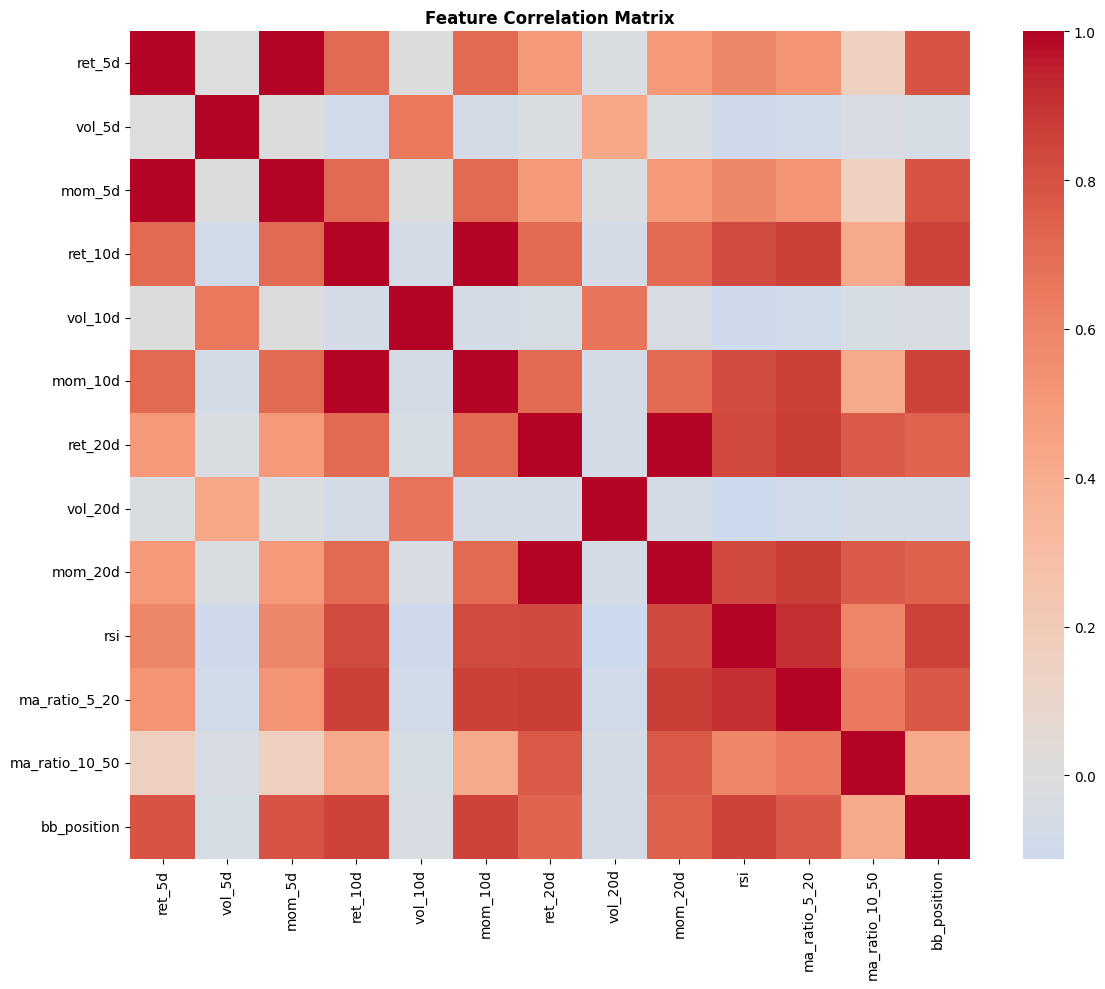

In [4]:
# ============================================================
# FEATURE CORRELATION MATRIX
# ============================================================

print("FEATURE CORRELATIONS")
print("="*60)

corr_matrix = df[feature_cols].corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr = abs(corr_matrix.iloc[i, j])
        if corr > 0.8:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr))

high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nHighly correlated pairs (>0.8):")
for f1, f2, corr in high_corr_pairs[:10]:
    print(f"  {f1} <-> {f2}: {corr:.3f}")

# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Feature Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

## Part 2: Mutual Information

MUTUAL INFORMATION

Top 10 by Mutual Information:
  ret_5d               0.0190
  mom_20d              0.0171
  ma_ratio_10_50       0.0122
  bb_position          0.0095
  vol_5d               0.0035
  ret_20d              0.0003
  mom_5d               0.0000
  ret_10d              0.0000
  vol_10d              0.0000
  mom_10d              0.0000


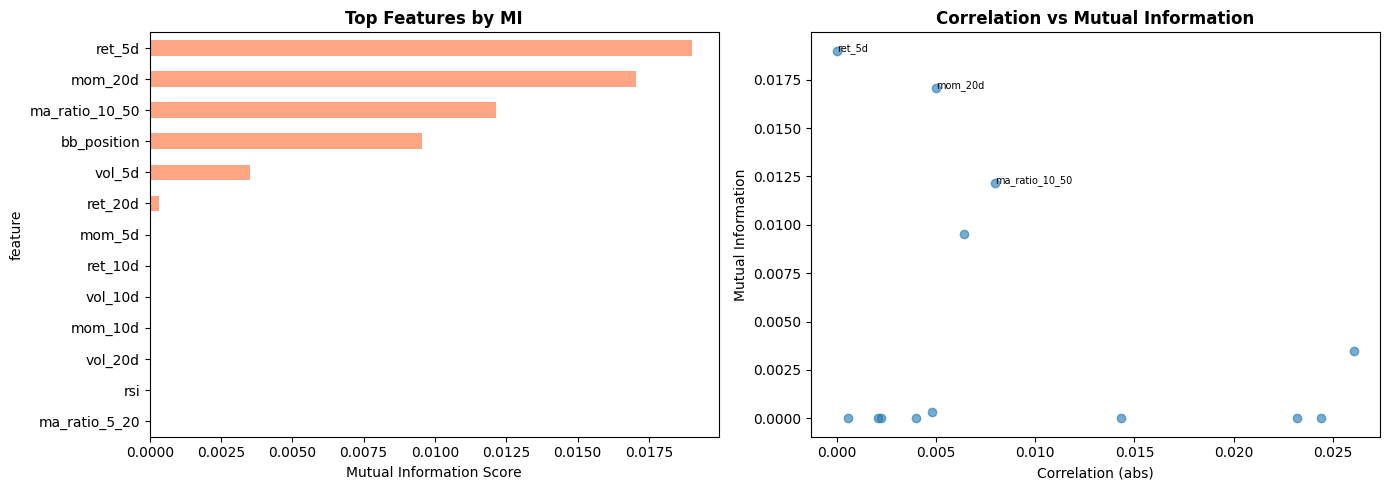

In [5]:
# ============================================================
# MUTUAL INFORMATION
# ============================================================

print("MUTUAL INFORMATION")
print("="*60)

X = df[feature_cols].values
y = df['target'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate MI
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)

mi_df = pd.DataFrame({
    'feature': feature_cols,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\nTop 10 by Mutual Information:")
for _, row in mi_df.head(10).iterrows():
    print(f"  {row['feature']:<20} {row['mi_score']:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mi_df.head(15).plot(x='feature', y='mi_score', kind='barh', ax=axes[0], 
                    color='coral', alpha=0.7, legend=False)
axes[0].set_xlabel('Mutual Information Score')
axes[0].set_title('Top Features by MI', fontweight='bold')
axes[0].invert_yaxis()

# Compare MI vs Correlation
comparison = pd.DataFrame({
    'feature': feature_cols,
    'correlation': correlations[feature_cols].values,
    'mi': mi_scores
})

axes[1].scatter(comparison['correlation'], comparison['mi'], alpha=0.6)
for _, row in comparison.iterrows():
    if row['mi'] > 0.01 or row['correlation'] > 0.03:
        axes[1].annotate(row['feature'], (row['correlation'], row['mi']), fontsize=7)
axes[1].set_xlabel('Correlation (abs)')
axes[1].set_ylabel('Mutual Information')
axes[1].set_title('Correlation vs Mutual Information', fontweight='bold')

plt.tight_layout()
plt.show()

## Part 3: Remove Redundant Features

In [6]:
# ============================================================
# REMOVE REDUNDANT FEATURES
# ============================================================

print("REMOVING REDUNDANT FEATURES")
print("="*60)

def remove_correlated_features(df, feature_cols, threshold=0.85):
    """
    Remove highly correlated features, keeping the one with
    higher correlation to target.
    """
    corr_matrix = df[feature_cols].corr().abs()
    target_corr = df[feature_cols].corrwith(df['target']).abs()
    
    to_drop = set()
    
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            if corr_matrix.iloc[i, j] > threshold:
                f1, f2 = feature_cols[i], feature_cols[j]
                
                # Drop the one with lower target correlation
                if target_corr[f1] >= target_corr[f2]:
                    to_drop.add(f2)
                else:
                    to_drop.add(f1)
    
    return [f for f in feature_cols if f not in to_drop], list(to_drop)

selected_features, dropped = remove_correlated_features(df, feature_cols, threshold=0.85)

print(f"\nOriginal features: {len(feature_cols)}")
print(f"After removing redundant: {len(selected_features)}")
print(f"\nDropped: {dropped}")
print(f"\nKept: {selected_features}")

REMOVING REDUNDANT FEATURES

Original features: 13
After removing redundant: 7

Dropped: ['rsi', 'mom_10d', 'ret_10d', 'ret_20d', 'ret_5d', 'mom_20d']

Kept: ['vol_5d', 'mom_5d', 'vol_10d', 'vol_20d', 'ma_ratio_5_20', 'ma_ratio_10_50', 'bb_position']


In [7]:
# ============================================================
# FINAL SELECTION
# ============================================================

print("FINAL SELECTED FEATURES")
print("="*60)

# Use SelectKBest to pick top features
X_selected = df[selected_features].values
selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(X_selected, y)

final_features = [f for f, s in zip(selected_features, selector.get_support()) if s]

print(f"\nFinal {len(final_features)} features:")
for f in final_features:
    mi = mi_df[mi_df['feature'] == f]['mi_score'].values
    mi_val = mi[0] if len(mi) > 0 else 0
    print(f"  • {f} (MI: {mi_val:.4f})")

FINAL SELECTED FEATURES

Final 7 features:
  • vol_5d (MI: 0.0035)
  • mom_5d (MI: 0.0000)
  • vol_10d (MI: 0.0000)
  • vol_20d (MI: 0.0000)
  • ma_ratio_5_20 (MI: 0.0000)
  • ma_ratio_10_50 (MI: 0.0122)
  • bb_position (MI: 0.0095)


In [8]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║        DAY 3 COMPLETE: FILTER-BASED FEATURE SELECTION            ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Correlation analysis with target                             ║
║  ✓ Feature correlation matrix                                   ║
║  ✓ Mutual Information scoring                                   ║
║  ✓ Removing redundant (multicollinear) features                 ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 4 - Wrapper & Embedded Methods
""")


╔══════════════════════════════════════════════════════════════════╗
║        DAY 3 COMPLETE: FILTER-BASED FEATURE SELECTION            ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Correlation analysis with target                             ║
║  ✓ Feature correlation matrix                                   ║
║  ✓ Mutual Information scoring                                   ║
║  ✓ Removing redundant (multicollinear) features                 ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 4 - Wrapper & Embedded Methods

